<a href="https://colab.research.google.com/github/APre203/MLTopic1/blob/main/StutterClassification-CNN-SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install pydub

### Downloaded Full Audio Files

In [3]:
import os
import pathlib
import requests
# from pydub import AudioSegment
from pydub import AudioSegment
import numpy as np
import argparse

def wav_converter(episodes, wavs):

  episode_uri = episodes
  wav_dir = wavs

  # Load episode data
  table = np.loadtxt(episode_uri, dtype=str, delimiter=',')

  urls = table[:, 2]
  n_items = len(urls)

  audio_types = [".mp3", ".m4a", ".mp4"]

  for i in range(n_items):
      # Get show/episode IDs
      show_abrev = table[i, -2].strip()
      ep_idx = table[i, -1]
      episode_url = table[i, 2]
      # print(episode_url, ep_idx, show_abrev) # (https://media.talkbank.org/fluency/Voices-AWS/interview/46ma.mp4  010  FluencyBank)

      # Check file extension
      ext = ''
      for ext in audio_types:
          if ext in episode_url:
              break

      # Ensure the base folder exists for this episode
      episode_dir = pathlib.Path(f"{wav_dir}/{show_abrev}/")
      # print(episode_dir)
      os.makedirs(episode_dir, exist_ok=True)

      # Get file paths
      audio_path_orig = pathlib.Path(f"{episode_dir}/{ep_idx}{ext}")
      wav_path = pathlib.Path(f"{episode_dir}/{ep_idx}.wav")
      # print(audio_path_orig, wav_path) #"C:\Users\andrew\Downloads\ml-stuttering-events-dataset\wav\ FluencyBank\ 010.mp4"

      # Download raw audio file
      if not os.path.exists(audio_path_orig):
          response = requests.get(episode_url)
          with open(audio_path_orig, 'wb') as audio_file:
              audio_file.write(response.content)

      # Convert to 16khz mono wav file
      # print(audio_path_orig)
      audio = AudioSegment.from_file(audio_path_orig) #error here
      audio = audio.set_frame_rate(16000).set_channels(1)
      audio.export(wav_path, format="wav")

      os.remove(audio_path_orig)

In [4]:
wav_converter("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_episodes2.csv", "wav")

### Divided Audio Files Into 3 Second Clips

In [5]:

import os
import pathlib
import subprocess

import numpy as np
import pandas as pd
from scipy.io import wavfile

import argparse
def clip_maker(labels, wavs, clips):

  label_file = labels
  data_dir = wavs
  output_dir = clips


  # Load label/clip file
  data = pd.read_csv(label_file, dtype={"EpId":str})

  # Get label columns from data file
  shows = data.Show
  episodes = data.EpId
  clip_idxs = data.ClipId
  starts = data.Start
  stops = data.Stop
  labels = data.iloc[:,5:].values

  n_items = len(shows)

  loaded_wav = ""
  cur_iter = range(n_items)
  for i in cur_iter:
    clip_idx = clip_idxs[i]
    show_abrev = shows[i]
    episode = episodes[i].strip()

    # Setup paths
    wav_path = f"{data_dir}/{shows[i]}/{episode}.wav"
    # print(wav_path)
    clip_dir = pathlib.Path(f"{output_dir}/{show_abrev}/{episode}/")
    clip_path = f"{clip_dir}/{shows[i]}_{episode}_{clip_idx}.wav"

    if not os.path.exists(wav_path):
      print("Missing", wav_path)
      continue

    # Verify clip directory exists
    os.makedirs(clip_dir, exist_ok=True)

    # Load audio. For efficiency reasons don't reload if we've already open the file.
    if wav_path != loaded_wav:
      sample_rate, audio = wavfile.read(wav_path)
      assert sample_rate == 16000, "Sample rate must be 16 khz"

      # Keep track of the open file
      loaded_wav = wav_path

    # Save clip to file
    clip = audio[starts[i]:stops[i]]
    wavfile.write(clip_path, sample_rate, clip)


In [6]:
clip_maker("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels2.csv", "wav", "clips")

### Building Model Section / Preprocessing

In [14]:
import librosa
import librosa.feature
import soundfile as sf
import math
import tensorflow as tf

In [8]:
def mel_spectrogram(y,sr):
  window_size = 2048
  hop_length = 512
  # load audio file
  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=window_size, hop_length=hop_length, n_mels=90, center="True")

  log_mel_spectrogram = tf.expand_dims(librosa.power_to_db(mel_spectrogram), axis=2)
  return log_mel_spectrogram

In [9]:
def mfcc_converter(y, sr):
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50).T, axis=0)
  delta_mfccs = librosa.feature.delta(mfccs)
  delta2_mfccs = librosa.feature.delta(mfccs, order=2)
  # return np.concatenate((mfccs,delta_mfccs,delta2_mfccs))
  return mfccs

In [10]:
csv_file = "/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels2.csv" #create dataframe for testing file
csv_df = pd.read_csv(csv_file, delimiter=",", encoding='utf-8')

In [11]:

# p = "/content/clips/FluencyBank/10/"

def file_to_df(csv, clip_filename):

  # new_df = pd.DataFrame(columns=df.columns)  # Create an empty DataFrame
  new_df = pd.DataFrame(columns=csv_df.columns)
  n = 0  # Initialize a counter
  for index, row in csv.iterrows():

    # find each wav file
    path_name = f'{row["Show"]}_{row["EpId"]}_{row["ClipId"]}.wav'
    p = f'/content/{clip_filename}/FluencyBank/{row["EpId"]}/'
    y, sr = sf.read(p + path_name)

    # calculate spectro and mfcc for the wav fiel
    spectro = mel_spectrogram(y,sr)
    mfcc = mfcc_converter(y,sr)

    if row["NoStutteredWords"] >= 2:
      row["Stutter"] = 0 # didnt stutter
    else:
      row["Stutter"] = 1 # did stutter
    row["spect"] = spectro
    row["mfcc"] = mfcc
    new_df = new_df.append(row, ignore_index=True)  # Append the new row to the new DataFrame TRY CHANGEING IT TO pd.concat
    retval_df = new_df

  return retval_df

def balanced(df): # 0 -> didnt stutter -- 1 -> stutter
  count_stutter_0 = len(df[df["Stutter"] == 0])
  count_stutter_1 = len(df[df["Stutter"] == 1])
  number = min(count_stutter_0,count_stutter_1) # number of min(stutters,no-stutters)

  balanced_df_stutter_0 = df[df["Stutter"] == 0].sample(n=math.ceil(number))
  balanced_df_stutter_1 = df[df["Stutter"] == 1].sample(n=number)
  retval_balanced = pd.concat([balanced_df_stutter_0, balanced_df_stutter_1])
  return retval_balanced

In [ ]:
csv_sample = file_to_df(csv_df, "clips")

In [16]:
balanced_dataset = balanced(csv_sample) ### ???

In [17]:
from numpy.lib.function_base import average
import cv2

desired_length = 94

resized_spectrograms = []
resized_mfccs = []
labels = []

for spectrogram,mfcc, stut in zip(balanced_dataset["spect"], balanced_dataset["mfcc"], balanced_dataset["Stutter"]):

    # made sure all shapes are the same size
    data_resized = np.zeros((90, 94, 1))
    data_resized[:, :spectrogram.shape[1], :] = spectrogram

    resized_spectrograms.append(data_resized)
    # print(spectrogram.shape, data_resized.shape)
    # print(spectrogram.shape)
    resized_mfccs.append(mfcc)
    labels.append(stut)


data = np.array(resized_spectrograms)
mfcc_data = np.array(resized_mfccs)

labels = np.array(labels)



In [18]:
from sklearn.model_selection import train_test_split
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(mfcc_data, labels, test_size=0.2, random_state=42)

In [39]:
print(X_train_spec.shape)

(1796, 90, 94, 1)


### Build CNN Model

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input


model_cnn = Sequential()
model_cnn.add(Input(shape=(90, 94, 1)))
model_cnn.add(Conv2D(16, (3,3), activation='relu')) #, input_shape=(90, 94, 1)
model_cnn.add(Conv2D(16, (3,3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile('adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

hist = model_cnn.fit(X_train_spec, y_train_spec, epochs=13, validation_data=(X_test_spec, y_test_spec))

model_cnn.summary()

Epoch 1/13
57/57 [==============================] - 36s 560ms/step - loss: 17.6298 - recall_2: 0.5578 - precision_2: 0.5457 - val_loss: 0.6899 - val_recall_2: 0.7175 - val_precision_2: 0.5316
Epoch 2/13
57/57 [==============================] - 31s 551ms/step - loss: 0.4834 - recall_2: 0.8633 - precision_2: 0.8035 - val_loss: 0.7442 - val_recall_2: 0.6771 - val_precision_2: 0.5992
Epoch 3/13
57/57 [==============================] - 38s 668ms/step - loss: 0.1787 - recall_2: 0.9400 - precision_2: 0.9369 - val_loss: 0.9548 - val_recall_2: 0.6726 - val_precision_2: 0.5535
Epoch 4/13
57/57 [==============================] - 35s 618ms/step - loss: 0.0343 - recall_2: 0.9944 - precision_2: 0.9967 - val_loss: 1.2789 - val_recall_2: 0.6278 - val_precision_2: 0.6009
Epoch 5/13
57/57 [==============================] - 32s 561ms/step - loss: 0.0048 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 1.5110 - val_recall_2: 0.6637 - val_precision_2: 0.5873
Epoch 6/13
57/57 [==========================

### Build SVM Model

In [20]:
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import accuracy_score

model_svm = svm.SVC(kernel='linear') #'linear', 'sigmoid', 'precomputed', 'poly', 'rbf'
model_svm.fit(X_train_mfcc, y_train_mfcc)

y_pred_mfcc = model_svm.predict(X_test_mfcc)

print(classification_report(y_test_mfcc, y_pred_mfcc))

# accuracy = accuracy_score(y_test_mfcc, y_pred_mfcc)



              precision    recall  f1-score   support

         0.0       0.63      0.73      0.68       227
         1.0       0.67      0.57      0.62       223

    accuracy                           0.65       450
   macro avg       0.65      0.65      0.65       450
weighted avg       0.65      0.65      0.65       450



### Converting Test Cases

In [21]:
wav_converter("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_episodes_test.csv", "test")
clip_maker("/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels_test.csv", "test", "test_clips")

### Testing Test Cases

In [74]:
def didnt_or_did(n1,n2): # 0 for noStutter 1 for Stutter
  if n1 > n2:
    return 0
  return 1

In [ ]:
test_file = "/content/drive/MyDrive/ml-stuttering-events-dataset/fluencybank_labels_test.csv"
test_df = pd.read_csv(test_file, delimiter=",", encoding='utf-8')
test_sample = file_to_df(test_df, "test_clips") #2nd parameter doesnt matter total tests about 600 results

In [24]:
def test_svm(test_sample, model):
  y_true = []
  y_pred = []
  for mfcc, stutter in zip(test_sample["mfcc"], test_sample["Stutter"]):
    predicted = model.predict(mfcc.reshape(1, -1)) #array.reshape(1, -1)
    y_true.append(stutter)
    y_pred.append(predicted)
  return [y_true, y_pred]

In [75]:
def test_cnn(test_sample, model):
  y_true = []
  y_pred = []
  total_spect = []
  for spect, stutter in zip(test_sample["spect"], test_sample["Stutter"]):
    width, height = 128, 128
    # print(sum(spect))
    data_resized = np.zeros((1, 90, 94, 1))
    data_resized[:, :, :spect.shape[1], :] = spect
    resized_spectrogram = data_resized

    pred = model.predict(resized_spectrogram)

    total_spect.append(resized_spectrogram)
    y_pred.append(pred)

    y_true.append(stutter)

  test = np.array(total_spect)


  return [y_true, y_pred]

In [76]:
def test_model(test_sample, model, name):
  if name == "svm":
    return test_svm(test_sample, model)
  else: # model name is cnn
    return test_cnn(test_sample, model)

In [77]:
from sklearn.metrics import confusion_matrix

name = "cnn"

def confusion(ys):
  y_true, y_pred = ys[0], ys[1]

  confusion = confusion_matrix(y_true, y_pred)

  # print(confusion) #[[TP, FP][FN, TN]]
  return confusion


import matplotlib.pyplot as plt
from sklearn import metrics
def roc(ys):

  y_true, y_pred = ys[0], ys[1]

  fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title('ROC Curve')
  plt.show()

### Results of CNN

In [ ]:
name = "cnn"
ys = test_model(test_sample, model_cnn, name)
y_true = ys[0]
y_pred = [1 if prediction > 0.5 else 0 for prediction in ys[1]]

ys = [y_true, y_pred]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.48      0.50       491
         1.0       0.58      0.61      0.60       577

    accuracy                           0.55      1068
   macro avg       0.55      0.55      0.55      1068
weighted avg       0.55      0.55      0.55      1068

Confusion Matrix:
 [[236 255]
 [224 353]]


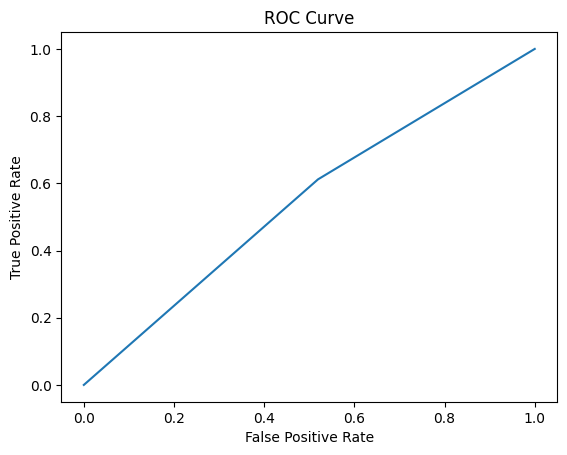

In [79]:
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
roc(ys)

### Result of SVM

In [30]:
name = "svm"
ys = test_model(test_sample, model_svm, name)
y_true, y_pred = ys[0], ys[1]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.49      0.60      0.54       491
         1.0       0.58      0.47      0.52       577

    accuracy                           0.53      1068
   macro avg       0.54      0.54      0.53      1068
weighted avg       0.54      0.53      0.53      1068

Confusion Matrix:
 [[296 195]
 [307 270]]


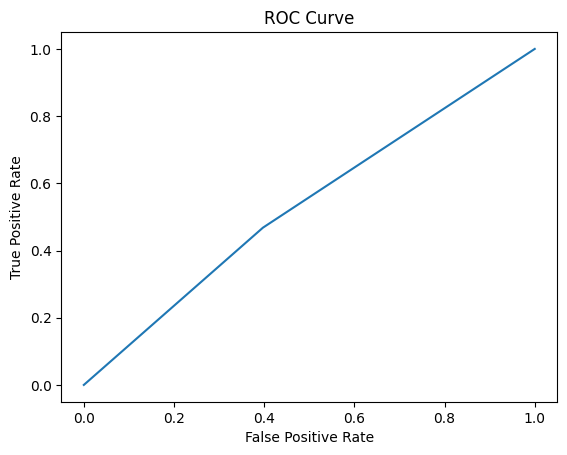

In [31]:
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
roc(ys)